In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import utils as u
u.check_python_version()
u.check_virtual_memory()

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Virtual memory usage - total: 31 GB / available: 25 GB / percent used: 18.9 %


In [2]:
# Open a dataset with monthly data
ds = xr.open_dataset(
    'snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc'
)
ds

<xarray.Dataset>
Dimensions:    (lat: 94, lon: 192, nbnds: 2, time: 1968)
Coordinates:
  * lat        (lat) float32 88.542 86.6531 84.7532 ... -86.6531 -88.542
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 354.375 356.25 358.125
  * time       (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    snowc      (time, lat, lon) float32 ...
Attributes:
    Conventions:             CF-1.2
    title:                   4x Daily NOAA-CIRES 20th Century Reanalysis V2c
    platform:                Model
    institution:             NOAA ESRL Physical Sciences Division & CU/CIRES ...
    citation:                Compo,G.P. <http://www.esrl.noaa.gov/psd/people/...
    version:                 2c
    contact:                 esrl.psd.data@noaa.gov
    source:                  20CRv2c 2014, Ensemble Kalman Filter, ocean (spe...
    forcing_note:            Additional information on the exte

In [3]:
# Get the variable and perdiod
da = ds.snowc.sel(time=slice('1984', '2014'))
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


## Make month weights
http://xarray.pydata.org/en/stable/examples/monthly-means.html  
(bug leap year fixed: https://github.com/pydata/xarray/pull/3464)

In [4]:
# Days per month for different calendar types
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [5]:
# Deal with leap years
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [6]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(da.time.to_index(), calendar='gregorian'),
                            coords=[da.time], name='month_length')
month_length

<xarray.DataArray 'month_length' (time: 372)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,

In [7]:
# Check leap year
import calendar

year = 2000

print(calendar.isleap(year))
month_length.sel(time=str(year))

True


<xarray.DataArray 'month_length' (time: 12)>
array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01

## Yearly mean

### Compute the weights

In [8]:
da

<xarray.DataArray 'snowc' (time: 372, lat: 94, lon: 192)>
[6713856 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * time     (time) datetime64[ns] 1984-01-01 1984-02-01 ... 2014-12-01
Attributes:
    long_name:         Monthly Snow Cover at Surface
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             %
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid


In [9]:
import calendar as cld
cld.month_abbr[2]

'Feb'

In [83]:
season = 'DJF'
month_length = xr.DataArray(
    get_dpm(da.time.to_index(), calendar='gregorian'), coords=[da.time], name='month_length'
)
    
# Deal with custom season (string or int for single month)
month = da['time.month']

if isinstance(season, int):
    # TODO: à finir
    season_sel = (month == season)
    
elif isinstance(season, str) and len(season) > 1:
    season_str = 'JFMAMJJASONDJFMAMJJASOND'

    month_start = season_str.index(season) + 1
    month_end = month_start + len(season) - 1

    if month_end > 12:
        month_end -= 12
        season_sel = (month >= month_start) | (month <= month_end)
        seasonal_data = da.sel(time=season_sel)[month_end:-(12-month_start+1)]
        seasonal_month_length = month_length.astype(float).sel(time=season_sel)[month_end:-(12-month_start+1)]
        weights = xr.DataArray(
            [value/seasonal_month_length.resample(time='AS-'+cld.month_abbr[month_start]).sum().values[i//len(season)] \
                 for i, value in enumerate(seasonal_month_length.values)],
            coords = [month_length.sel(time=season_sel)[month_end:-(12-month_start+1)].time],
            name = 'weights'
                              )
        
        sum_weights = weights.resample(time='AS-'+cld.month_abbr[month_start]).sum()
        np.testing.assert_allclose(sum_weights.values, np.ones(sum_weights.size))
        
        season_mean = (seasonal_data * weights).resample(time='AS-'+cld.month_abbr[month_start]).sum('time', skipna=False)
        
        
    else:
        # Checked with CDO (!cdo yearmonmean -selmonth,'' in.nc out.nc)
        season_sel = (month >= month_start) & (month <= month_end)
        seasonal_data = da.sel(time=season_sel)
        normalize = month_length.astype(float).sel(time=season_sel).groupby('time.year').sum()
        weights = month_length.sel(time=season_sel).groupby('time.year') / normalize
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(normalize.size))
        
        season_mean = (seasonal_data * weights).groupby('time.year').sum('time', skipna=False)
        

else:
    raise ValueError('The season is not valid (string or int for single month)')


# TODO : est-ce qu'on change la climatologie ?
# TODO : mettre en place les tests
# np.testing.assert_allclose(weights.sum().values, np.ones(1))

In [77]:
season = 'DJF'
month_length = xr.DataArray(
    get_dpm(da.time.to_index(), calendar='gregorian'), coords=[da.time], name='month_length'
)
    
# Deal with custom season (string or int for single month)
month = da['time.month']

if isinstance(season, int):
    # TODO: à finir
    season_sel = (month == season)
    
elif isinstance(season, str) and len(season) > 1:
    season_str = 'JFMAMJJASONDJFMAMJJASOND'

    month_start = season_str.index(season) + 1
    month_end = month_start + len(season) - 1

    if month_end > 12:
        month_end -= 12
        season_sel = (month >= month_start) | (month <= month_end)
        seasonal_data = da.sel(time=season_sel)
        normalize = month_length.astype(float).sel(time=season_sel).groupby('time.year').sum()
        weights = month_length.sel(time=season_sel).groupby('time.year') / normalize
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(normalize.size))
        
        season_mean = (seasonal_data * weights).groupby('time.year').sum('time', skipna=False)
        
    else:
        # Checked with CDO (!cdo yearmonmean -selmonth,'' in.nc out.nc)
        season_sel = (month >= month_start) & (month <= month_end)
        seasonal_data = da.sel(time=season_sel)
        normalize = month_length.astype(float).sel(time=season_sel).groupby('time.year').sum()
        weights = month_length.sel(time=season_sel).groupby('time.year') / normalize
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(normalize.size))
        
        season_mean = (seasonal_data * weights).groupby('time.year').sum('time', skipna=False)
        

else:
    raise ValueError('The season is not valid (string or int for single month)')


# TODO : est-ce qu'on change la climatologie ?
# TODO : mettre en place les tests
# np.testing.assert_allclose(weights.sum().values, np.ones(1))

<IPython.core.display.Javascript object>


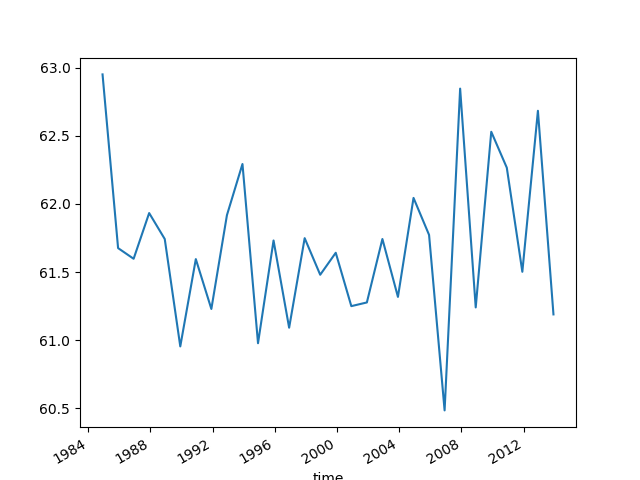

/home/lalandmi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [62]:
plt.figure()
season_mean.mean(dim=('lat','lon')).plot()

In [63]:
!cdo yearmonmean -selmonth,'12,1,2' snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc \
                                   snowc.DJF_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc

cdo(2) selmonth: Process started
Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo(2) selmonth: Processed 1678650 values from 2 variables over 372 timesteps
cdo yearmonmean: Processed 1678650 values from 2 variables [0.04s 59MB]


In [82]:
!cdo yearmonmean -shifttime,-2mo -selmonth,'10,11,12' snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc \
                                   snowc.DJF_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc

cdo(2) shifttime: Process started
cdo(3) selmonth: Process started
Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo(3) selmonth: Processed 1678650 values from 2 variables over 372 timesteps
cdo(2) shifttime: Processed 1678650 values from 2 variables
cdo yearmonmean: Processed 1678650 values from 2 variables [0.04s 59MB]


In [80]:
season_mean.year

<xarray.DataArray 'year' (year: 31)>
array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014])
Coordinates:
  * year     (year) int64 1984 1985 1986 1987 1988 ... 2010 2011 2012 2013 2014

In [87]:
cdo = xr.open_dataset('snowc.DJF_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc').snowc
cdo

<xarray.DataArray 'snowc' (time: 31, lat: 94, lon: 192)>
[559488 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1984-09-01 1985-09-01 ... 2014-09-01
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actu

In [45]:
!cdo yearmonmean -selmonth,'3,4,5,6' snowc.mon.noaaV2c_198401_201412_2.0x1.75.nc \
                                   snowc.MAMJ_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc

cdo(2) selmonth: Process started
Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo(2) selmonth: Processed 2238200 values from 2 variables over 372 timesteps
cdo yearmonmean: Processed 2238200 values from 2 variables [0.04s 59MB]


In [72]:
cdo = xr.open_dataset('snowc.MAMJ_yearmonmean.noaaV2c_198401_201412_2.0x1.75.nc').snowc
cdo

<xarray.DataArray 'snowc' (time: 31, lat: 94, lon: 192)>
[559488 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1984-04-16 1985-04-16 ... 2014-04-16
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
Attributes:
    long_name:         Monthly Snow Cover at Surface
    units:             %
    cell_methods:      time: mean (monthly from 3-hourly values)
    precision:         2
    GRIB_id:           238
    GRIB_name:         SNOWC
    var_desc:          snow cover
    dataset:           NOAA-CIRES 20th Century Reanalysis version 2c Monthly ...
    level_desc:        Surface
    statistic:         Ensemble Mean
    parent_stat:       Individual Obs
    standard_name:     
    statistic_method:  Ensemble mean is calculated by averaging over all 56 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actu

<IPython.core.display.Javascript object>


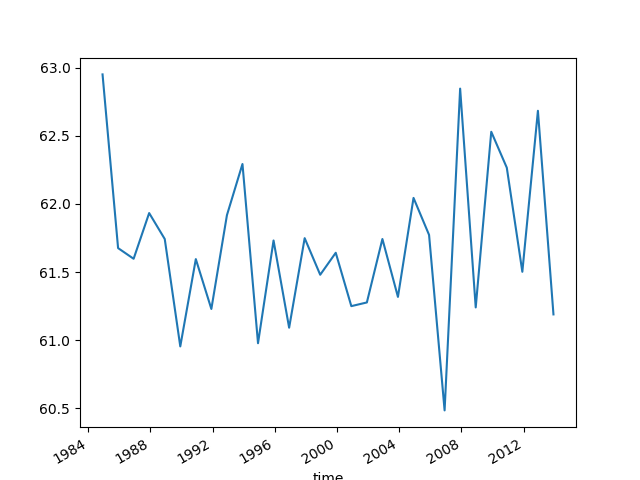

In [84]:
plt.figure()
season_mean.mean(dim=('lat','lon')).plot()

<IPython.core.display.Javascript object>


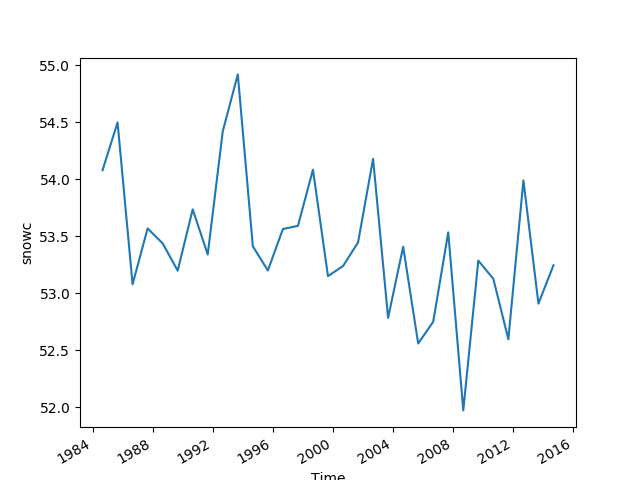

In [88]:
plt.figure()
cdo.mean(dim=('lat','lon')).plot()

In [67]:
cdo.mean(dim=('lat','lon')).values-season_mean.mean(dim=('lat','lon')).values

ValueError: operands could not be broadcast together with shapes (31,) (30,) 

<IPython.core.display.Javascript object>


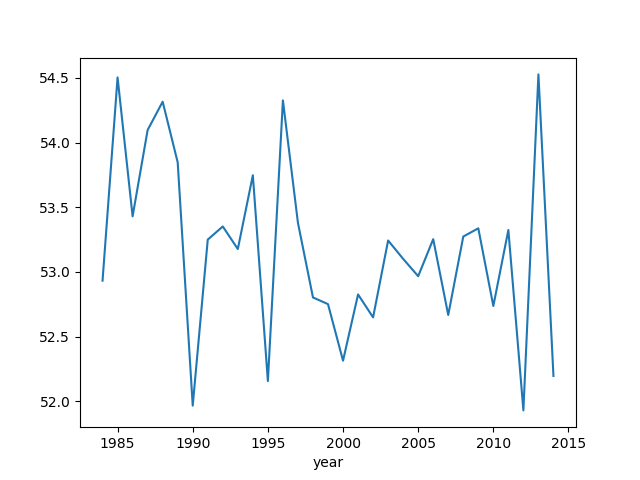

In [21]:
plt.figure()
season_mean.mean(dim=('lat','lon')).plot()

In [55]:
(seasonal_data * weights).groupby('time.year').sum('time', skipna=False)

<xarray.DataArray (year: 31, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100

In [ ]:
def season_mean(ds, season, calendar='standard'):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar), coords=[ds.time], name='month_length')
    
    # Deal with custom season (string or int for single month)
    month = ds['time.month']
    
    if isinstance(season, int):
        season_sel = (month == season)
    elif isinstance(season, str) and len(season) > 1:
        season_str = 'JFMAMJJASONDJFMAMJJASOND'
        
        month_start = season_str.index(season) + 1
        month_end = month_start + len(season) - 1

        if month_end > 12:
            month_end -= 12
            season_sel = (month >= month_start) | (month <= month_end)
        else:
            season_sel = (month >= month_start) & (month <= month_end)
        
    else:
        raise ValueError('The season is not valid (string or int for single month)')
        
    seasonal_data = ds.sel(time=season_sel)
    weights = month_length.sel(time=season_sel) / month_length.astype(float).sel(time=season_sel).sum()
    np.testing.assert_allclose(weights.sum().values, np.ones(1))

    if isinstance(season, int):
        return (seasonal_data * weights).sum(dim='time', skipna=False).assign_coords(month=season)
    elif isinstance(season, str) and len(season) > 1:
        return (seasonal_data * weights).sum(dim='time', skipna=False).assign_coords(season=season)

### Compute the seasonal climatology

In [11]:
# Calculate the weighted average
year_mean_weighted = (da * weights).groupby('time.year').sum(dim='time', skipna=False)
year_mean_not_weighted = da.groupby('time.year').mean(dim='time', skipna=False)

In [12]:
year_mean_weighted

<xarray.DataArray (year: 31, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100

### Plot the results

<IPython.core.display.Javascript object>


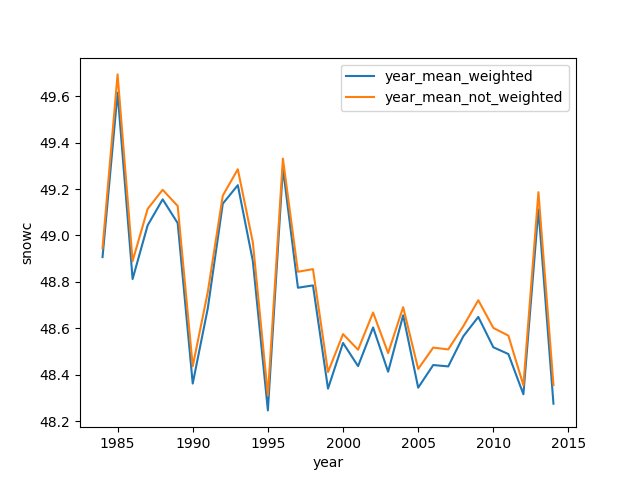

In [13]:
# Be aware that the cell area is taken into account here for the example
plt.figure()
year_mean_weighted.mean(dim=('lat', 'lon')).plot(label='year_mean_weighted')
year_mean_not_weighted.mean(dim=('lat', 'lon')).plot(label="year_mean_not_weighted")
plt.legend()

## With utils.year_mean function

In [14]:
year_mean = u.year_mean(da, calendar='gregorian')
year_mean

<xarray.DataArray (year: 31, lat: 94, lon: 192)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100., 100.],
        [100., 100., 100., ..., 100., 100

<IPython.core.display.Javascript object>


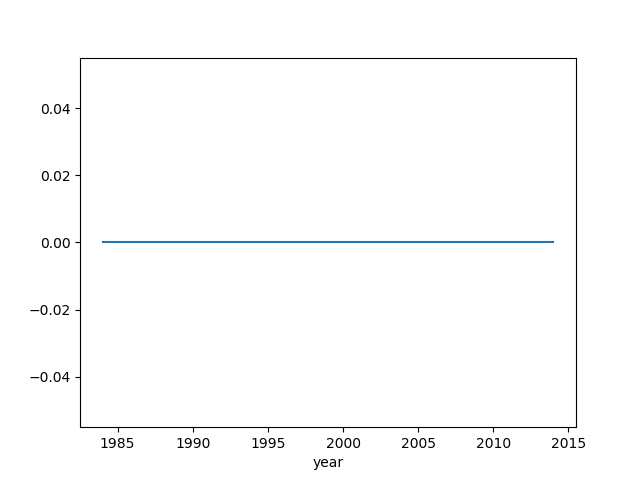

In [15]:
# Check that it is the same
plt.figure()
(year_mean_weighted-year_mean).mean(dim=('lat', 'lon')).plot()

# Check CDO results

In [16]:
!cdo yearmean /home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc yearmean.nc

Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo yearmean: Processed 35522400 values from 2 variables over 2131 timesteps [1.42s 180MB]


In [17]:
!cdo yearmonmean /home/msantola/TP_CLiMAF/ReferenceSNOW/SNC/SNCRefData/snowc.mon.noaaV2c_185101_201412_2.0x1.75.nc yearmonmean.nc

Warning (cdfDefVar): Changed double entry of variable name 'time_bnds' to 'time_bnds_2'!
cdo yearmonmean: Processed 35522400 values from 2 variables over 2131 timesteps [1.65s 180MB]


In [18]:
year_mean_cdo = xr.open_dataset('yearmean.nc').snowc.sel(time=slice('1984', '2014'))
year_mon_mean_cdo = xr.open_dataset('yearmonmean.nc').snowc.sel(time=slice('1984', '2014'))

Figure 3  
/home/mlalande/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:  Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:  
	>>> from pandas.plotting import register_matplotlib_converters  
	>>> register_matplotlib_converters()  
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


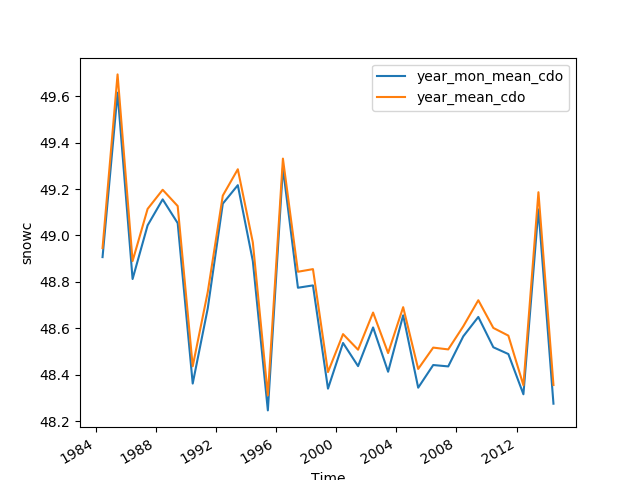

In [19]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure()
year_mon_mean_cdo.mean(dim=('lat', 'lon')).plot(label='year_mon_mean_cdo')
year_mean_cdo.mean(dim=('lat', 'lon')).plot(label='year_mean_cdo')
plt.legend()

In [20]:
year_mean.coords

Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * year     (year) int64 1984 1985 1986 1987 1988 ... 2010 2011 2012 2013 2014

In [21]:
year_mon_mean_cdo.coords

Coordinates:
  * time     (time) datetime64[ns] 1984-06-16 1985-06-16 ... 2014-06-16
  * lon      (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.375 356.25 358.125
  * lat      (lat) float32 88.542 86.6531 84.7532 ... -84.7532 -86.6531 -88.542

In [22]:
temp = year_mean.copy()
temp.values = year_mon_mean_cdo.values

<IPython.core.display.Javascript object>


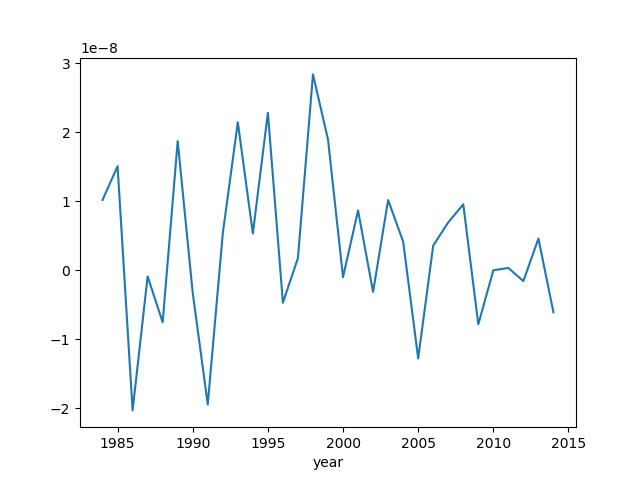

In [23]:
# Check that it is the same
plt.figure()
(year_mean_weighted-temp).mean(dim=('lat', 'lon')).plot()

### Spatial check

<IPython.core.display.Javascript object>


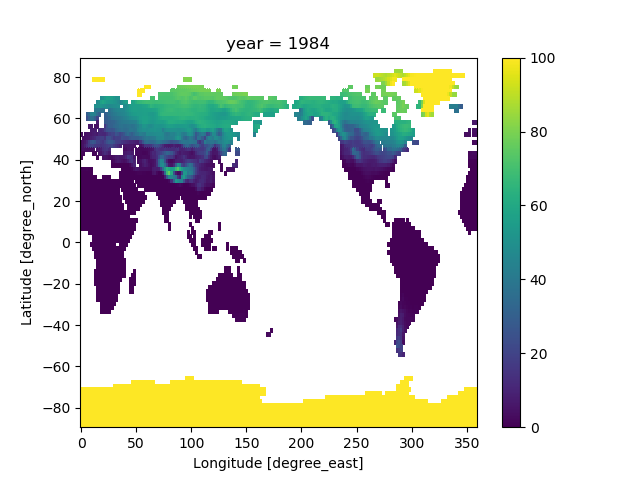

In [24]:
plt.figure()
year_mean[0].plot()

<IPython.core.display.Javascript object>


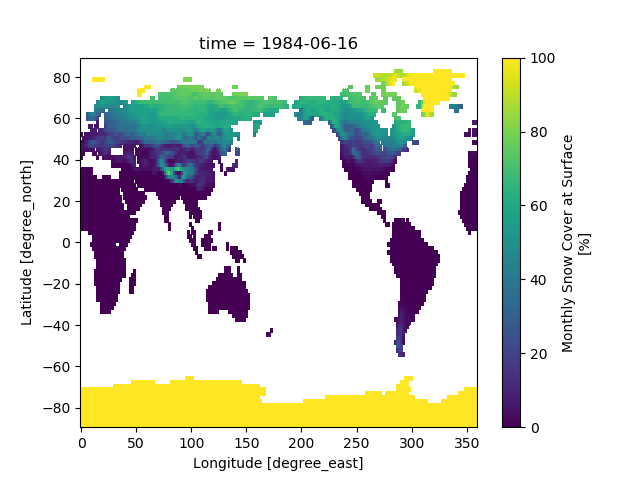

In [25]:
plt.figure()
year_mon_mean_cdo[0].plot()

<IPython.core.display.Javascript object>


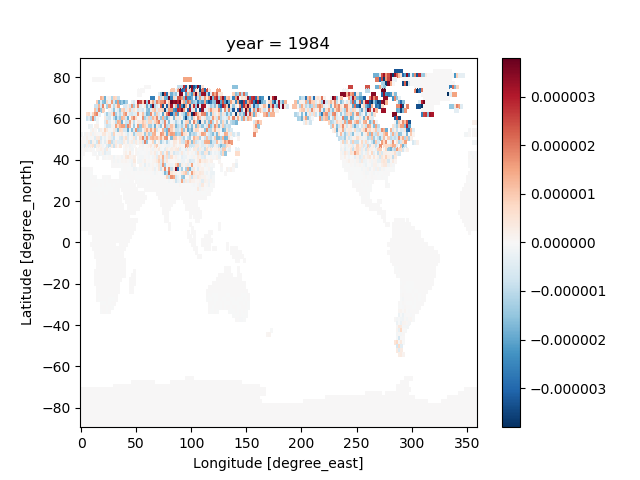

In [26]:
plt.figure()
(year_mean[0]-temp[0]).plot()